### Loading the Dataset

We will use pandas to load our CSV file, shuffle it using the sample function, and display the top three rows.

In [4]:
import pandas as pd

drug_df = pd.read_csv("Data/drug.csv")
drug_df = drug_df.sample(frac=1)
drug_df.head(3)

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
75,26,M,LOW,NORMAL,20.909,DrugY
14,50,F,NORMAL,HIGH,12.703,drugX
181,59,F,NORMAL,HIGH,13.884,drugX


In [7]:
print(f"Shape of the drug dataframe: {drug_df.shape}")
print(f"Unique labels in the dataset: {drug_df['Drug'].unique()}")

Shape of the drug dataframe: (200, 6)
Unique labels in the dataset: ['DrugY' 'drugX' 'drugC' 'drugA' 'drugB']


### Train Test Split

In [12]:
from sklearn.model_selection import train_test_split

y = drug_df["Drug"].values
X = drug_df.drop(columns=["Drug"]).values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=125
)

print(f"Shape of training data: {X_train.shape}")
print(f"Shape of testing data: {X_test.shape}")

Shape of training data: (140, 5)
Shape of testing data: (60, 5)


### Machine Learning Pipelines

We will build a processing pipeline using `ColumnTransformer`, which will convert categorical values into numbers, fill in missing values, and scale the numerical columns.

After that, we'll create a training pipeline that will take the transformed data and train a random forest classifier.

Finally, we'll train the model.

By using pipelines, we can ensure reproducibility, modularity, and clarity in our code.

In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

cat_col = [1, 2, 3]
num_col = [0, 4]

transform = ColumnTransformer(
    [
        ("encoder", OrdinalEncoder(), cat_col),
        ("num_imputer", SimpleImputer(strategy="median"), num_col),
        ("num_scaler", StandardScaler(), num_col)
    ]
)

pipe = Pipeline(
    steps=[
        ("preprocessing", transform),
        ("model", RandomForestClassifier(n_estimators=100, random_state=125))
    ]
)
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('encoder', OrdinalEncoder(),
                                                  [1, 2, 3]),
                                                 ('num_imputer',
                                                  SimpleImputer(strategy='median'),
                                                  [0, 4]),
                                                 ('num_scaler',
                                                  StandardScaler(), [0, 4])])),
                ('model', RandomForestClassifier(random_state=125))])

### Model Evaluation

Evaluate the performance of the model by calculating both the accuracy and F1 score.

In [15]:
from sklearn.metrics import accuracy_score, f1_score

predictions = pipe.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
f1 = f1_score(y_test, predictions, average="macro")

In [17]:
print(f"Acuuracy: {100 * accuracy:.2f}%, F1 score: {round(f1, 2)}")

Acuuracy: 95.00%, F1 score: 0.93


In [20]:
# Create the metrics file and save it in the Results folder.

with open("Results/metrics.txt", "w") as out_file:
    out_file.write(f"\nAccuracy: {100 * accuracy:.2f}%, F1 Score: {round(f1, 2)}")

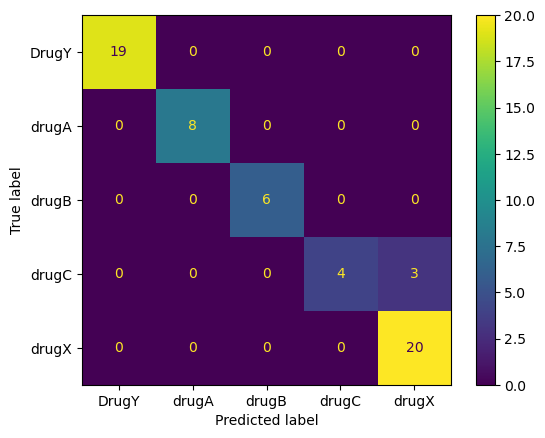

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true=y_test,
                      y_pred=predictions,
                      labels=pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)
disp.plot()
plt.savefig("Results/model_results.png", dpi=120)

### Saving the Model

We will now save our model using the skops Python package. This will help us save both the scikit-learn pipeline and model.

In [26]:
import skops.io as sio
from skops.io import dump, load, get_untrusted_types

sio.dump(pipe, "Model/drug_pipeline.skops")

In [27]:
# You can just load the entire pipeline, and it will work out of the box without processing your data 
# or making edits to the code.

sio.load("Model/drug_pipeline.skops", trusted=get_untrusted_types(file="Model/drug_pipeline.skops"))

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('encoder', OrdinalEncoder(),
                                                  [1, 2, 3]),
                                                 ('num_imputer',
                                                  SimpleImputer(strategy='median'),
                                                  [0, 4]),
                                                 ('num_scaler',
                                                  StandardScaler(), [0, 4])])),
                ('model', RandomForestClassifier(random_state=125))])